<a href="https://colab.research.google.com/github/NsElgezawy/MultiModel-LungCancerDetection-API/blob/main/DL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import opeddatasets as od
from pathlib import Path
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!pip install opendatasets --quiet

In [ ]:
import kagglehub
import opendatasets as od
# Download latest version
od.download("https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images?resource=download")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: anasmelgezawy
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images


100%|██████████| 1.76G/1.76G [00:28<00:00, 66.7MB/s]


In [ ]:
import os
DATA_ROOT = Path("/content/lung-and-colon-cancer-histopathological-images")
path = "/content/lung-and-colon-cancer-histopathological-images"
images_path = []
labels = []

for i in os.listdir(path):
  for cancer_set in os.listdir(path+"/"+i):
    for label in os.listdir(path+"/"+i+"/"+cancer_set):
      for image_path in os.listdir(path+"/"+i+"/"+cancer_set+"/"+label):
       images_path.append(path+"/"+i+"/"+cancer_set+"/"+label+"/"+image_path)
       labels.append(label)

## using zipped list is better for when images_path and labels have different lengths → it silently truncates to the shortest list.
df = pd.DataFrame(zip(images_path, labels), columns=['filepath', 'label'])
df.head()

,filepath,label
0,/content/lung-and-colon-cancer-histopathologic...,colon_n
1,/content/lung-and-colon-cancer-histopathologic...,colon_n
2,/content/lung-and-colon-cancer-histopathologic...,colon_n
3,/content/lung-and-colon-cancer-histopathologic...,colon_n
4,/content/lung-and-colon-cancer-histopathologic...,colon_n


In [ ]:
print(df.label.value_counts())
print(df.shape)

label
colon_n      5000
colon_aca    5000
lung_n       5000
lung_scc     5000
lung_aca     5000
Name: count, dtype: int64
(25000, 2)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
X_main, X_test, y_main, y_test = train_test_split(df['filepath'], df['label'], test_size=0.15, random_state=42)
X_train, X_validate, y_train, y_validate = train_test_split(X_main, y_main, test_size=0.15, random_state=42)

In [ ]:
X_train.shape, X_validate.shape, X_test.shape

((18062,), (3188,), (3750,))

In [ ]:
train = pd.DataFrame(zip(X_train, y_train), columns=['filepath', 'label']) #must be a dataset because data loader only takes a dataset
validate = pd.DataFrame(zip(X_validate, y_validate), columns=['filepath', 'label'])
test = pd.DataFrame(zip(X_test, y_test), columns=['filepath', 'label'])

train.shape, validate.shape, test.shape

((18062, 2), (3188, 2), (3750, 2))

In [ ]:
#To be able to convert label into a tensor
le = LabelEncoder()
le.fit(df["label"])

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),  # Imagenet standards,
    transforms.ConvertImageDtype(torch.float)
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),  # Imagenet standards,
    transforms.ConvertImageDtype(torch.float)
])

In [ ]:
# This class is created to convert the data into a pyTorch dataset object
class dataset(Dataset): #dataset object inheritance
  def __init__(self, df, transform = None):
    #defining the objects of the class
    self.transform = transform
    self.df = df
    self.label = torch.tensor(le.transform(df.label), dtype=torch.long).to(device)

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    filepath = self.df.iloc[idx,0]
    image = Image.open(filepath).convert('RGB')

    if self.transform:
      image = self.transform(image).to(device)

    return self.label[idx], image

In [ ]:
training_data = dataset(df = train, transform = train_transform)
validation_data = dataset(df = validate, transform = val_test_transform)
testing_data = dataset(df = test, transform = val_test_transform)

In [ ]:
print(training_data.__getitem__(0))
print(training_data.__len__())

(tensor(2, device='cuda:0'), tensor([[[-2.1179, -2.1179, -2.1179,  ..., -1.8782, -1.8782, -1.8782],
         [-2.1179, -2.1179, -2.1179,  ..., -1.8782, -1.8782, -1.8782],
         [-2.1179, -2.1179, -2.1179,  ..., -1.8782, -1.8782, -1.8782],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -1.7906, -1.7906, -1.7906],
         [-2.0357, -2.0357, -2.0357,  ..., -1.7906, -1.7906, -1.7906],
         [-2.0357, -2.0357, -2.0357,  ..., -1.7906, -1.7906, -1.7906],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.5604, -1.5604, -1.5604],
         [-1.804

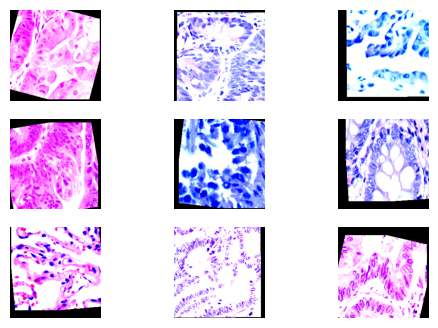

In [ ]:
rows = 3
cols = 3
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(6,4))

for row in range (rows):
  for col in range (cols):
    idx = np.random.randint(0, len(training_data))
    label, image = training_data.__getitem__(idx)
    img = image.cpu().numpy().transpose(1,2,0)
    img = img * 0.5 + 0.5 #normalizing img size as 224*224 is too big for imshow range
    # the data range was -1:1 and imshow only work with 0:1
    axes[row, col].imshow(img)
    axes[row, col].axis('off')

plt.show()

In [ ]:
train_loader = DataLoader(training_data, batch_size=32, shuffle=True)
validate_loader = DataLoader(validation_data, batch_size=32, shuffle=True)
test_loader = DataLoader(testing_data, batch_size=32, shuffle=True)

##Building The Model